## Introduction / Business Problem (for now)

Animal Crossing: New Horizons had a very prominent presence during the COVID-19 pandemic, and is one of the best-selling Switch games to this day. It had its period of glory, but is now a topic of controversy and debate surrounding Nintendo. I wanted to take on this dataset for analysis because I myself played Animal Crossing during the early days of the pandemic. It gave me something to do and I enjoyed it at the time, but I noticed that some people quickly became bored/burnt out with the lack of content, and I myself stopped playing after 9 months. I didn’t have the same experience as others, and because of that I want to know what the general populace thought of the game at the time by centering my project around Animal Crossing reviews.

If I were given the task to help Nintendo's dev team figure out new updates for New Horizons or help contribute ideas for the next title in the Animal Crossing series, I would want to look at reviews and feedback surrounding New Horizons to let them know what they did well and what they could improve on.

## Data

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

import nltk
import wordcloud

from sklearn.model_selection import train_test_split

In [2]:
user_df = pd.read_csv('data/user_reviews.csv')

user_df.head()

,grade,user_name,text,date
0,4,mds27272,My gf started playing before me. No option to ...,2020-03-20
1,5,lolo2178,"While the game itself is great, really relaxin...",2020-03-20
2,0,Roachant,My wife and I were looking forward to playing ...,2020-03-20
3,0,Houndf,We need equal values and opportunities for all...,2020-03-20
4,0,ProfessorFox,BEWARE! If you have multiple people in your h...,2020-03-20


Scores among users are heavily polarized

<AxesSubplot:>

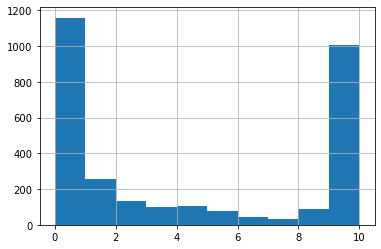

In [4]:
user_df['grade'].hist()

In [5]:
user_df['text']

0       My gf started playing before me. No option to ...
1       While the game itself is great, really relaxin...
2       My wife and I were looking forward to playing ...
3       We need equal values and opportunities for all...
4       BEWARE!  If you have multiple people in your h...
                              ...                        
2994    1 Island for console limitation.I cannot play ...
2995    Per giocare con figli o fidanzate, mogli o per...
2996    One island per console is a pathetic limitatio...
2997    Even though it seems like a great game with ma...
2998    Game is fantastic.Nintendo deciding that you c...
Name: text, Length: 2999, dtype: object